### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings('ignore')

I0000 00:00:1764248869.591214  419908 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1764248869.902134  419908 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1764248872.051676  419908 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.21.0-dev20251013
Num GPUs: 1


W0000 00:00:1764248875.833280  419908 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [5]:
df = pd.read_csv('../data/data_cleaned.csv')
df.head()

,Tweet,Label
0,terlepas kadang alurnya bikin kesal tapi terim...,Cinta
1,bagian terseram caraka malam ditengah hutan be...,Takut
2,saya sadar saya ini siapa kamu siapa dan takka...,Sedih
3,kalau memang tak ada niatan lebih tolong janga...,Sedih
4,sekuat kuatnya orang yang selalu riang tertawa...,Sedih


### Persiapan Dataset

In [6]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 9342
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [7]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.1,  # 10% = 1000 samples untuk test
    stratify=df["LabelEncoded"],
    random_state=42
)

# Split train_val menjadi train dan val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.11,  # 15% dari total = 1000 samples
    stratify=train_val_labels,
    random_state=42
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")

Train: 7,482 samples
Val: 925 samples
Test: 935 samples (UNTOUCHED)


### Load Tokenizer

In [8]:
LOCAL_DIR = "../local-xlmr-tf"
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)

### Define Function CV

In [9]:
def create_efficient_dataset(texts, labels, batch_size=8, max_length=96):
    """Membuat dataset secara efisien"""
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="tf"
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def objective(trial):
    """Objective function tanpa CV - menggunakan fixed validation set"""

    # Hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    max_length = trial.suggest_categorical("max_length", [64, 96, 128])
    epochs = trial.suggest_int("epochs", 3, 6)

    print(
        f"  Trial {trial.number} - LR: {learning_rate:.2e}, Batch: {batch_size}, Epochs: {epochs}")

    # Buat datasets menggunakan fixed train/val split (bukan CV)
    train_dataset = create_efficient_dataset(
        train_texts, train_labels, batch_size, max_length)
    val_dataset = create_efficient_dataset(
        val_texts, val_labels, batch_size, max_length)

    # Buat model
    model = TFAutoModelForSequenceClassification.from_pretrained(
        LOCAL_DIR,
        num_labels=num_labels,
        local_files_only=True
    )

    # FIX: Gunakan optimizer yang compatible
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Training dengan early stopping
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True,
                verbose=0
            )
        ]
    )

    # Gunakan best validation accuracy (bukan epoch terakhir)
    best_val_accuracy = max(history.history['val_accuracy'])

    print(f"    Val Accuracy: {best_val_accuracy:.4f}")

    # Clear memory
    tf.keras.backend.clear_session()
    del model

    return best_val_accuracy

### Define Function Objective

In [10]:
study = optuna.create_study(
    direction='maximize',  # Maximize accuracy
    storage="sqlite:///xlmr2.db",
    study_name="xlmr",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
)

N_TRIALS = 20

[I 2025-11-27 20:07:57,037] Using an existing study with name 'xlmr' instead of creating a new one.


In [11]:
completed = len([t for t in study.trials if t.state == TrialState.COMPLETE])
remaining = max(0, N_TRIALS - completed)
print("Completed:", completed, "Remaining to run:", remaining)

Completed: 20 Remaining to run: 0


### Hyperparameter TUning

In [12]:
print("Starting Hyperparameter Optimization...")
study.optimize(objective, 
               n_trials=remaining, 
               show_progress_bar=True)

Starting Hyperparameter Optimization...


In [13]:
# Print results
print("\n" + "="*60)
print("BEST HYPERPARAMETERS (INCLUDING EPOCH)")
print("="*60)
print(f"Best CV Accuracy: {study.best_value:.4f}")
print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

best_params = study.best_trial.params


BEST HYPERPARAMETERS (INCLUDING EPOCH)
Best CV Accuracy: 0.8116

Best Hyperparameters:
  learning_rate: 1.2231822374746584e-05
  batch_size: 16
  max_length: 96
  epochs: 4


In [14]:
print("\n" + "="*50)
print("ALL TRIALS ANALYSIS")
print("="*50)
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False)
print(trials_df[['number', 'value', 'params_learning_rate', 'params_batch_size',
                 'params_epochs', 'params_max_length']].head(10))


ALL TRIALS ANALYSIS
    number     value  params_learning_rate  params_batch_size  params_epochs  \
19      19  0.811563              0.000012                 16              4   
20      20  0.808351              0.000012                 32              4   
2        2  0.807281              0.000011                 32              3   
15      15  0.804069              0.000018                 16              4   
14      14  0.802998              0.000007                  8              3   
4        4  0.799786              0.000006                  8              3   
3        3  0.796574              0.000003                  8              4   
1        1  0.796574              0.000004                  8              6   
13      13  0.795503              0.000018                 32              3   
11      11  0.792291              0.000033                 32              5   

    params_max_length  
19                 96  
20                 96  
2                  64  
15

### Trai final Model

In [15]:
# Split data untuk final training
print(f"Using BEST parameters from Optuna:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Gunakan seluruh train_val data untuk training final
print(f"Training final model on {len(train_val_texts):,} samples...")

Using BEST parameters from Optuna:
  learning_rate: 1.2231822374746584e-05
  batch_size: 16
  max_length: 96
  epochs: 4
Training final model on 8,407 samples...


In [16]:
# Buat dataset final dengan best parameters
final_train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

final_val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

final_train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(final_train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

final_val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(final_val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1764248877.289634  419908 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1764248877.643543  419908 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [17]:
# Buat model final
final_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ../local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [18]:
# Training
print("Starting final training")
history_final = final_model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=best_params['epochs'],
    verbose=1
)


Starting final training
Epoch 1/4


E0000 00:00:1764248900.399333  419908 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1764248902.060577  420046 service.cc:158] XLA service 0x7e2ec002cb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764248902.060634  420046 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1764248902.112908  420039 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764248902.167364  420043 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1764248902.299687  420043 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 [==============================] - 102s 172ms/step - loss: 1.0507 - accuracy: 0.5981 - val_loss: 0.6499 - val_accuracy: 0.7773
Epoch 2/4
468/468 [==============================] - 70s 150ms/step - loss: 0.6187 - accuracy: 0.7912 - val_loss: 0.6360 - val_accuracy: 0.7827
Epoch 3/4
468/468 [==============================] - 69s 148ms/step - loss: 0.5055 - accuracy: 0.8324 - val_loss: 0.6204 - val_accuracy: 0.7859
Epoch 4/4
468/468 [==============================] - 69s 148ms/step - loss: 0.4025 - accuracy: 0.8637 - val_loss: 0.6814 - val_accuracy: 0.7784


In [19]:
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

### Evaluasi

In [41]:
val_loss, val_acc = final_model.evaluate(final_val_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Epochs Used: 4")


FINAL RESULTS
Validation Loss: 0.6814
Validation Accuracy: 0.7784
Epochs Used: 4


In [20]:
test_loss, test_accuracy = final_model.evaluate(test_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Epochs Used: 4")



FINAL RESULTS
Test Loss: 0.7362
Test Accuracy: 0.7733
Epochs Used: 4


In [21]:
# Predictions dan detailed report
pred_logits = final_model.predict(test_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_labels,
                            target_names=label_names, digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Cinta     0.7030    0.8345    0.7632       139
     Gembira     0.8182    0.7930    0.8054       227
       Marah     0.8000    0.7628    0.7810       215
       Sedih     0.7443    0.6583    0.6987       199
       Takut     0.7811    0.8516    0.8148       155

    accuracy                         0.7733       935
   macro avg     0.7693    0.7800    0.7726       935
weighted avg     0.7750    0.7733    0.7723       935



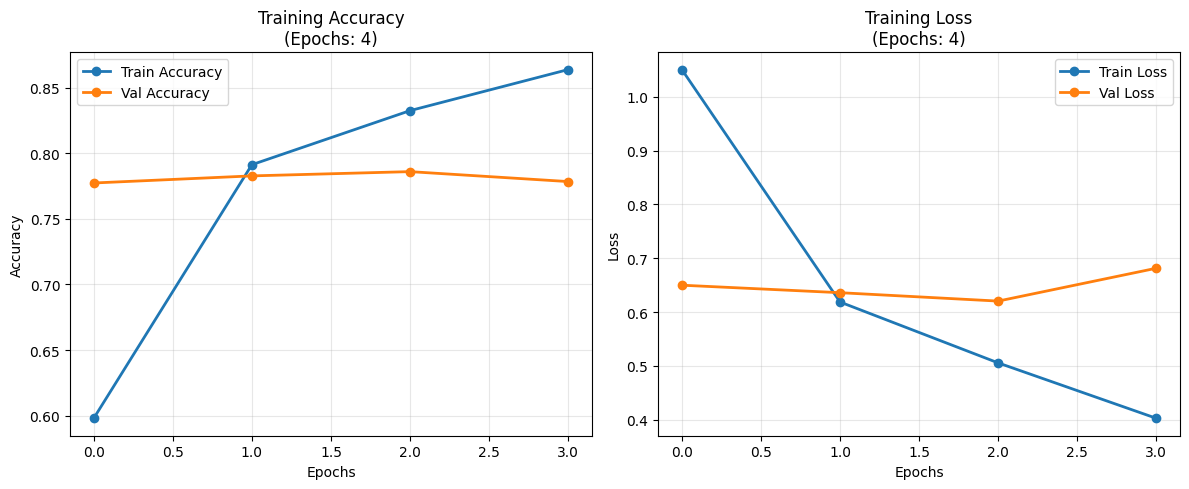

In [34]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy\n(Epochs: {best_params["epochs"]})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss\n(Epochs: {best_params["epochs"]})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

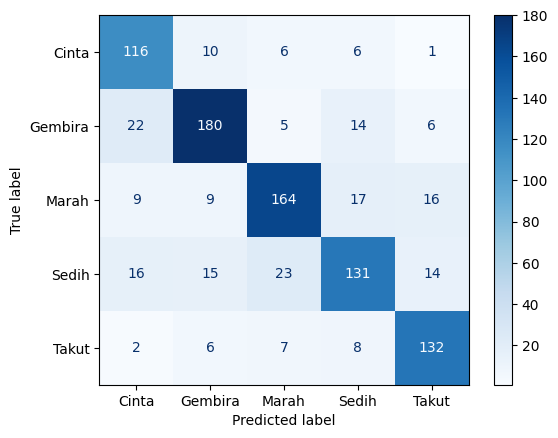

In [23]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

In [24]:
SAVE_DIR = "./xlmr_Model"

os.makedirs(SAVE_DIR, exist_ok=True)

final_model.save_pretrained(f'{SAVE_DIR}')
tokenizer.save_pretrained(f'{SAVE_DIR}')

('./xlmr_Model/tokenizer_config.json',
 './xlmr_Model/special_tokens_map.json',
 './xlmr_Model/tokenizer.json')

### Inferensi Model

In [25]:
# MODEL_PATH = './IndoBert_Model/'
# TOKENIZER_PATH = './IndoBert_Model/'

In [26]:
# #Load tokenizer dan model
# tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
# model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

In [27]:
EXTERNAL_TEST_PATH = "../data/external_test.csv"

try:
    # Load external dataset
    external_df = pd.read_csv(EXTERNAL_TEST_PATH)

    # Cek struktur dataset
    print(f"External dataset shape: {external_df.shape}")
    print(f"Columns: {external_df.columns.tolist()}")
    print(f"First few rows:")
    print(external_df.head())

    # Asumsi format: harus ada kolom 'Tweet' dan 'Label'
    if 'Tweet' not in external_df.columns or 'Label' not in external_df.columns:
        print("❌ Error: External dataset must have 'Tweet' and 'Label' columns")
        # Jika format berbeda, adjust sesuai kebutuhan
        # Contoh: jika kolom bernama 'text' dan 'sentiment'
        if 'text' in external_df.columns and 'sentiment' in external_df.columns:
            print("⚠️  Found 'text' and 'sentiment' columns, renaming...")
            external_df = external_df.rename(
                columns={'text': 'Tweet', 'sentiment': 'Label'})
        else:
            # Cari kolom yang mungkin berisi text dan label
            text_col = None
            label_col = None
            for col in external_df.columns:
                if external_df[col].dtype == 'object' and len(external_df[col].iloc[0]) > 10:
                    text_col = col
                elif external_df[col].dtype == 'object' and len(external_df[col].iloc[0]) < 20:
                    label_col = col

            if text_col and label_col:
                print(
                    f"⚠️  Using '{text_col}' as Tweet and '{label_col}' as Label")
                external_df = external_df.rename(
                    columns={text_col: 'Tweet', label_col: 'Label'})
            else:
                raise ValueError(
                    "Could not identify text and label columns automatically")

    print(f"✅ External dataset loaded: {len(external_df)} samples")
    print(f"Class distribution in external data:")
    print(external_df['Label'].value_counts())

except FileNotFoundError:
    print(f"❌ Error: File not found at {EXTERNAL_TEST_PATH}")
    print("Please check the file path and try again.")
    exit()
except Exception as e:
    print(f"❌ Error loading external dataset: {str(e)}")
    exit()

External dataset shape: (2235, 2)
Columns: ['Label', 'Tweet']
First few rows:
   Label                                        Tweet
0  Cinta  saya sayang sama semua impian dan harapanmu
1  Cinta                            saya sayang halus
2  Cinta                            kamu adalah sobat
3  Cinta                              cinta kita arti
4  Cinta                             cinta kita tetap
✅ External dataset loaded: 2235 samples
Class distribution in external data:
Label
Cinta      473
Gembira    473
Marah      470
Takut      424
Sedih      395
Name: count, dtype: int64


In [28]:
from sklearn.preprocessing import LabelEncoder

# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

# Load label names dari model training (asumsi Anda punya)
# Jika tidak, kita akan menggunakan yang dari external data
try:
    # Coba load label names dari file atau gunakan default
    label_names = ['Cinta', 'Gembira', 'Marah',
                   'Sedih', 'Takut']  # Adjust sesuai training Anda
    print(f"Using label names from training: {label_names}")

    # Map external labels ke format training jika diperlukan
    label_mapping = {
        'love': 'Cinta', 'happy': 'Gembira', 'anger': 'Marah',
        'sad': 'Sedih', 'fear': 'Takut', 'joy': 'Gembira'
    }

    # Apply mapping jika ada perbedaan naming
    external_df['Label'] = external_df['Label'].map(
        label_mapping).fillna(external_df['Label'])

except:
    print("⚠️  Using labels from external data")
    label_names = sorted(external_df['Label'].unique())
    print(f"Label names: {label_names}")

# Encode labels
le = LabelEncoder()
le.fit(label_names)  # Fit dengan label names yang konsisten

try:
    external_df['LabelEncoded'] = le.transform(external_df['Label'])
    print("✅ Labels encoded successfully")
except ValueError as e:
    print(f"❌ Label encoding error: {str(e)}")
    print("This might indicate label mismatch between training and external data")
    print("Available labels in external data:", external_df['Label'].unique())
    print("Expected labels:", label_names)

    # Handle unknown labels
    unknown_labels = set(external_df['Label']) - set(label_names)
    print(f"Unknown labels: {unknown_labels}")

    # Filter hanya samples dengan known labels
    mask = external_df['Label'].isin(label_names)
    external_df = external_df[mask]
    external_df['LabelEncoded'] = le.transform(external_df['Label'])

    print(f"Filtered to {len(external_df)} samples with known labels")

print(f"Final external dataset: {len(external_df)} samples")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']
Using label names from training: ['Cinta', 'Gembira', 'Marah', 'Sedih', 'Takut']
✅ Labels encoded successfully
Final external dataset: 2235 samples


In [29]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

print(f"Tokenizing {len(external_texts)} samples...")

Tokenizing 2235 samples...


In [30]:
# Tokenize dengan parameter yang sama seperti training
def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=64,  # Gunakan max_length yang sama seperti training
        return_tensors="tf"
    )


external_encodings = tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)  # Batch size sama seperti training

print("✅ External data prepared for inference")

✅ External data prepared for inference


In [31]:
# Evaluate model
external_loss, external_accuracy = final_model.evaluate(external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {external_loss:.4f}")
print(f"External Test Accuracy: {external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")

# Predictions
print("\nGenerating predictions...")
pred_logits = final_model.predict(external_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)
pred_probs = tf.nn.softmax(pred_logits, axis=1)


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.8550
External Test Accuracy: 0.7727
Number of samples: 2235

Generating predictions...


In [32]:
# Classification Report
print("\nCLASSIFICATION REPORT (External Data):")
print(classification_report(
    external_true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))


CLASSIFICATION REPORT (External Data):
              precision    recall  f1-score   support

       Cinta     0.7034    0.5666    0.6276       473
     Gembira     0.7834    0.7801    0.7818       473
       Marah     0.8614    0.9255    0.8923       470
       Sedih     0.5996    0.7924    0.6827       395
       Takut     0.9607    0.8066    0.8769       424

    accuracy                         0.7727      2235
   macro avg     0.7817    0.7743    0.7723      2235
weighted avg     0.7840    0.7727    0.7729      2235



<Figure size 1000x800 with 0 Axes>

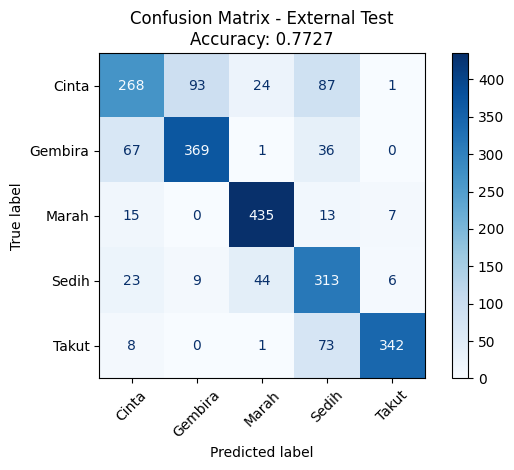

In [33]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(external_true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(
    f"Confusion Matrix - External Test\nAccuracy: {external_accuracy:.4f}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./external_test_confusion_matrix.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [35]:
experiment_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

experiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ../local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [36]:
history_final = experiment_model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
468/468 [==============================] - 107s 184ms/step - loss: 1.0729 - accuracy: 0.5925 - val_loss: 0.6982 - val_accuracy: 0.7741
Epoch 2/10
468/468 [==============================] - 75s 160ms/step - loss: 0.6331 - accuracy: 0.7915 - val_loss: 0.6251 - val_accuracy: 0.7978
Epoch 3/10
468/468 [==============================] - 71s 153ms/step - loss: 0.4977 - accuracy: 0.8355 - val_loss: 0.6382 - val_accuracy: 0.7849
Epoch 4/10
468/468 [==============================] - 72s 154ms/step - loss: 0.4086 - accuracy: 0.8627 - val_loss: 0.6586 - val_accuracy: 0.7914
Epoch 5/10
468/468 [==============================] - 73s 157ms/step - loss: 0.3250 - accuracy: 0.8924 - val_loss: 0.7175 - val_accuracy: 0.7935
Epoch 6/10
468/468 [==============================] - 71s 152ms/step - loss: 0.2623 - accuracy: 0.9146 - val_loss: 0.7351 - val_accuracy: 0.7773
Epoch 7/10
468/468 [==============================] - 72s 153ms/step - loss: 0.1961 - accuracy: 0.9374 - val_loss: 0.9119 - val_a

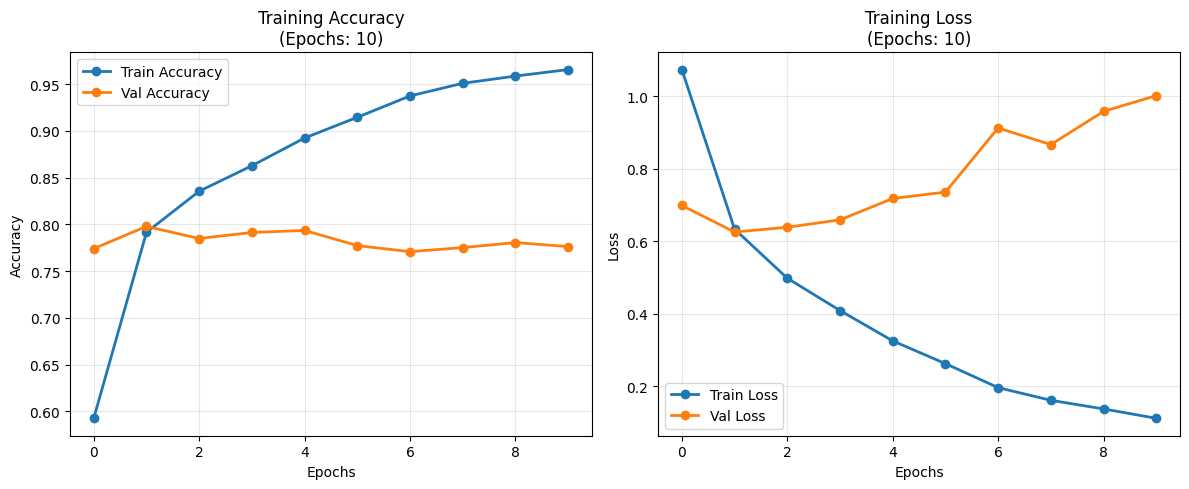

In [38]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
experiment_loss, experiment_accuracy = experiment_model.evaluate(test_dataset, verbose=0)
    
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {experiment_loss:.4f}")
print(f"Test Accuracy: {experiment_accuracy:.4f}")
print(f"Epochs Used: 10")


FINAL RESULTS
Test Loss: 0.9141
Test Accuracy: 0.7979
Epochs Used: 10


In [40]:
# Evaluate model
experimental_external_loss, experimental_external_accuracy = experiment_model.evaluate(
    external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {experimental_external_loss:.4f}")
print(f"External Test Accuracy: {experimental_external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 1.1500
External Test Accuracy: 0.7584
Number of samples: 2235
